# NLP Standard Project - Identifying Human Values behind Arguments

## Task

*Given a textual argument and a human value category, classify whether or not the argument draws on that category. This task uses a set of 20 value categories compiled from the social science literature and described in our [ACL paper](https://webis.de/publications.html#kiesel_2022b). Participants can submit runs (also known as approaches or systems) that detect one, a subset, or all of these values in arguments. Arguments are given as premise text, conclusion text, and binary stance of the premise to the conclusion ("in favor of" or "against").*

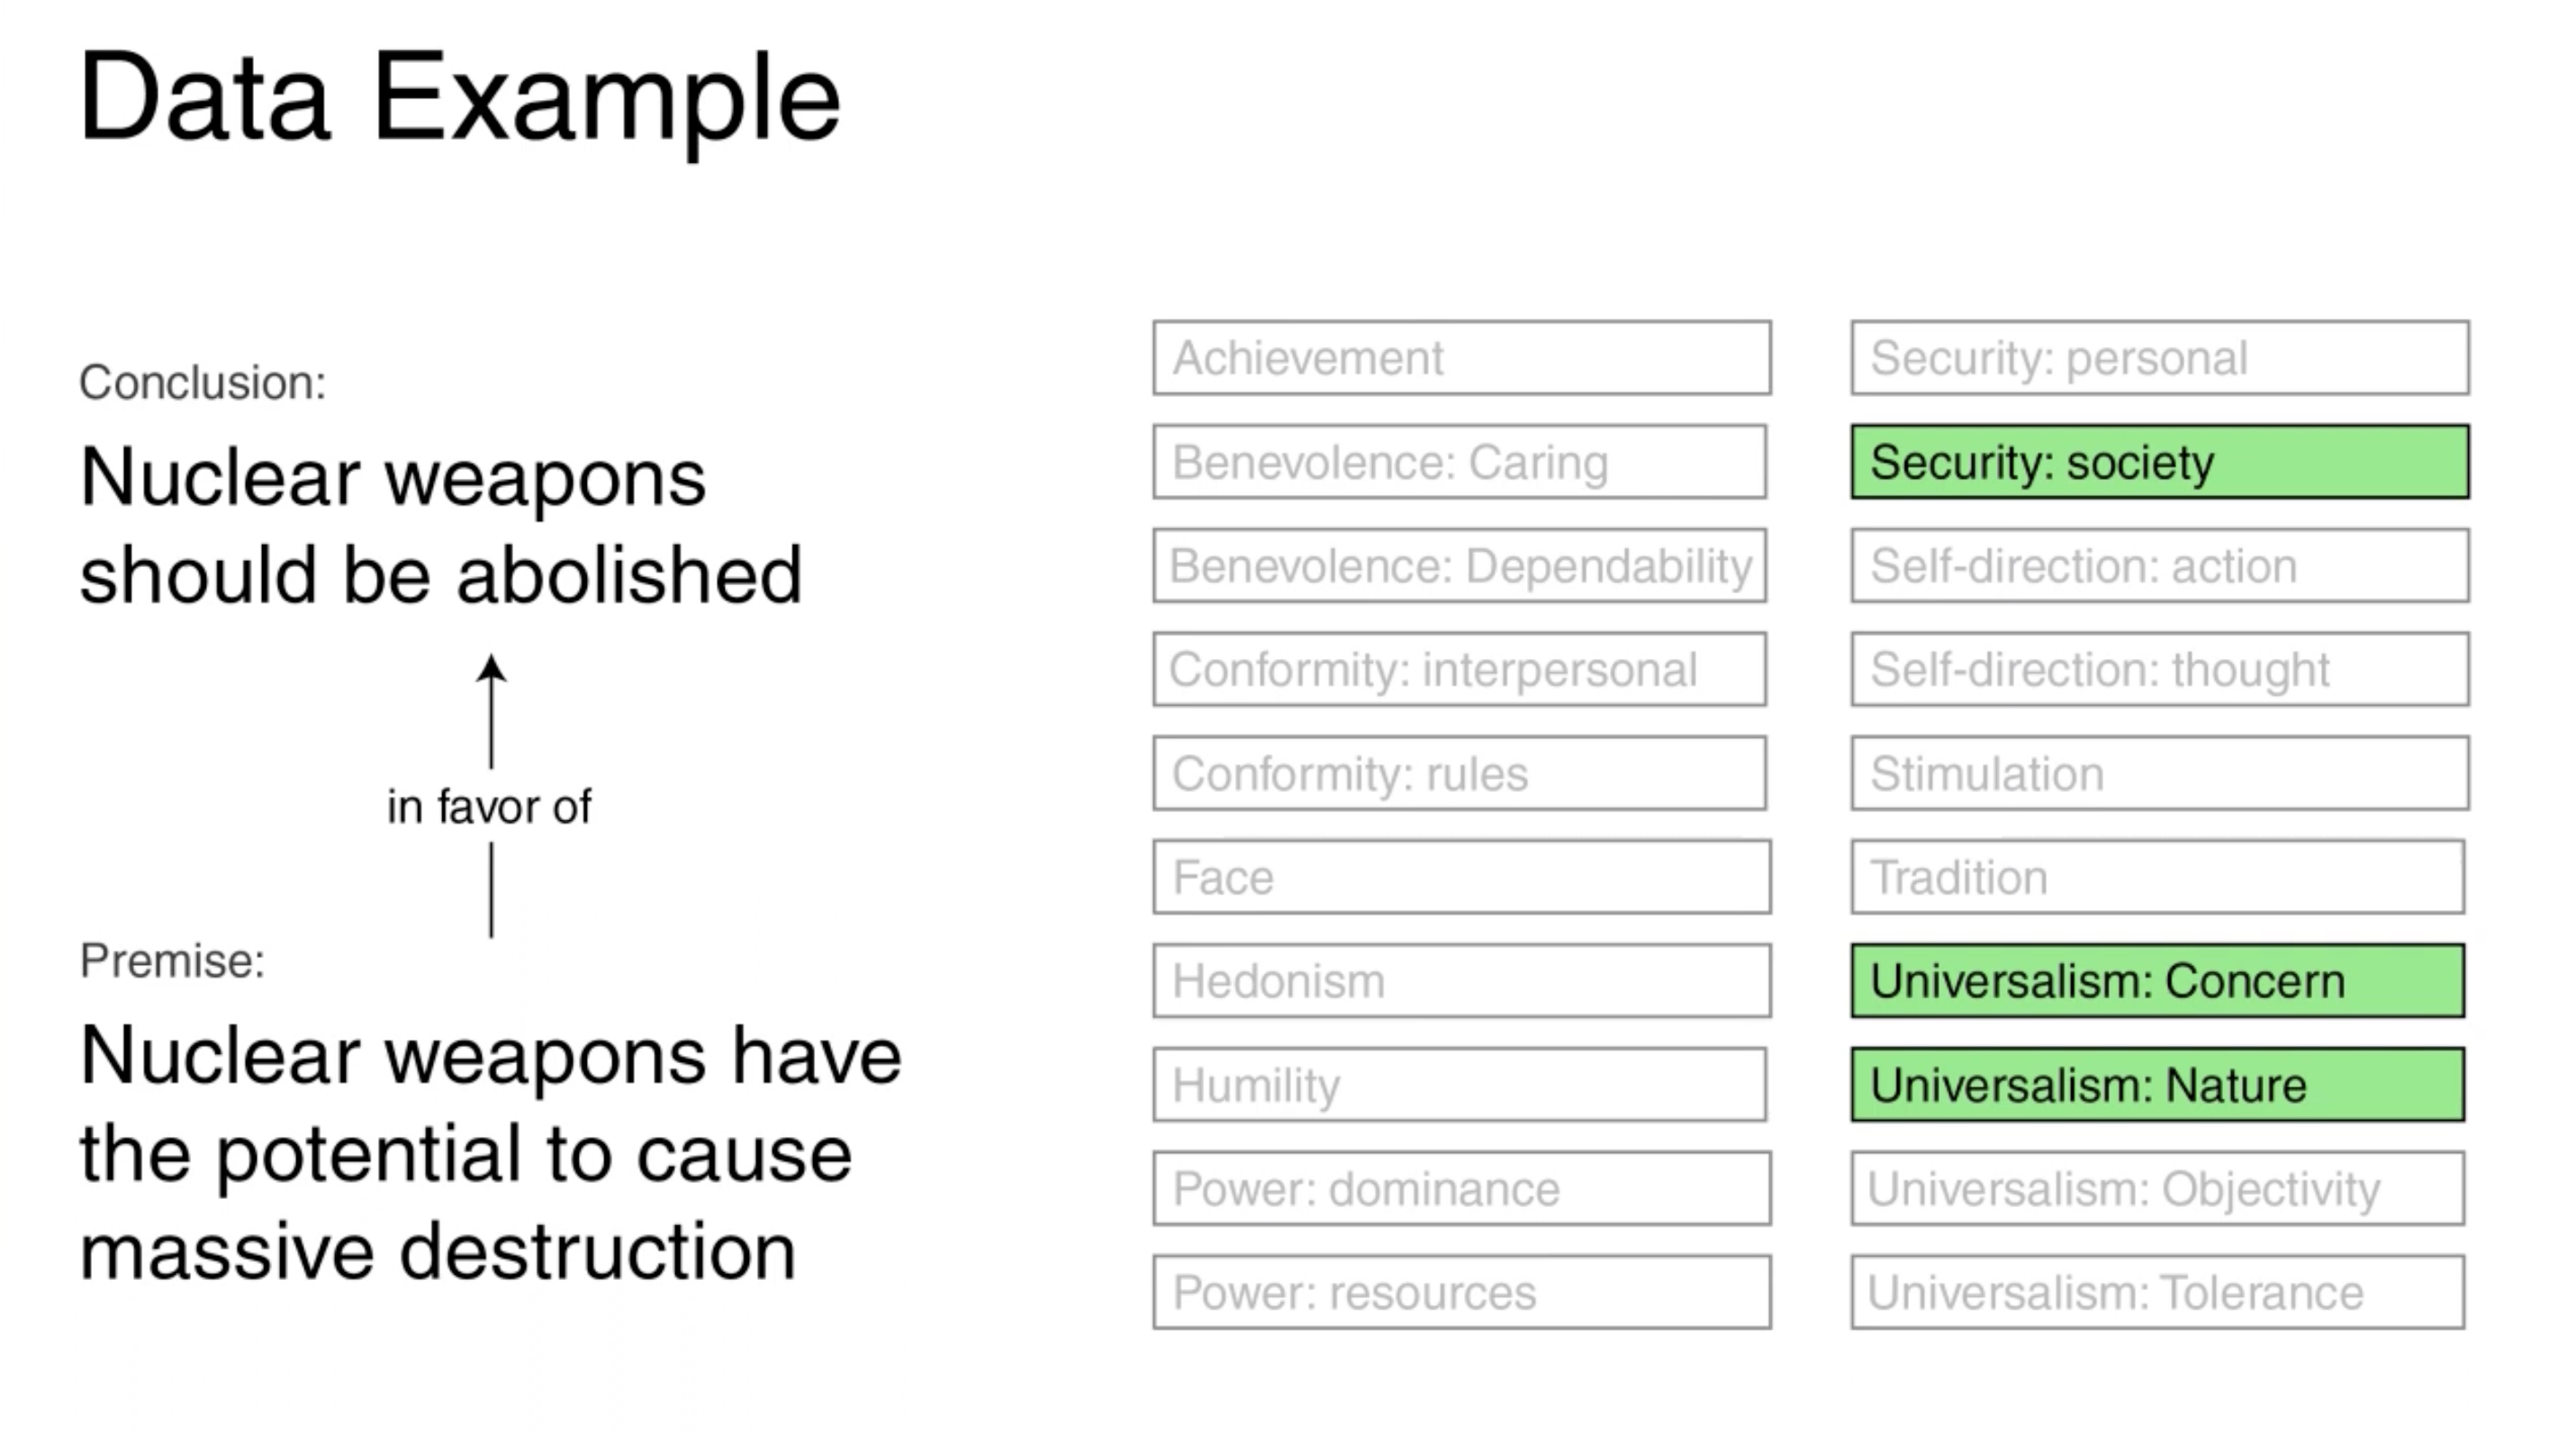

The 20 value categories are listed below in brief:
- *Self-direction: thought* - It is good to have own ideas and interests.
- *Self-direction: action* - It is good to determine one's own actions.
- *Stimulation* - It is good to experience excitement, novelty, and change.
- *Hedonism* - It is good to experience pleasure and sensual gratification.
- *Achievement* - It is good to be successful in accordance with social norms.
- *Power: dominance* - It is good to be in positions of control over others.
- *Power: resources* - It is good to have material possessions and social resources.
- *Face* - It is good to maintain one's public image.
- *Security: personal* - It is good to have a secure immediate environment.
- *Security: societal* - It is good to have a secure and stable wider society.
- *Tradition* - It is good to maintain cultural, family, or religious traditions.
- *Conformity: rules* - It is good to comply with rules, laws, and formal obligations.
- *Conformity: interpersonal* - It is good to avoid upsetting or harming others.
- *Humility* - It is good to recognize one's own insignificance in the larger scheme of things.
- *Benevolence: caring* - It is good to work for the welfare of one's group's members.
- *Benevolence: dependability* - It is good to be a reliable and trustworthy member of one's group.
- *Universalism: concern* - It is good to strive for equality, justice, and protection for all people.
- *Universalism: nature* - It is good to preserve the natural environment.
- *Universalism: tolerance* - It is good to accept and try to understand those who are different from oneself.
- *Universalism: objectivity* - It is good to search for the truth and think in a rational and unbiased way.

## Imports

*N.B.* `zenodo-get` is a Python package that provides a simple way to download data from the Zenodo reository. 

In [ ]:
!pip install transformers
!pip install evaluate
!pip install zenodo-get
!zenodo_get 10.5281/zenodo.7550385

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 32.0 MB/s eta 0:00:00

In [ ]:
import torch, re, nltk, transformers, warnings, random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from functools import reduce
from transformers import AutoTokenizer, AutoModelForSequenceClassification, EvalPrediction, TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import Dataset, DatasetDict
from typing import List, Callable
from sklearn.metrics import f1_score, precision_score, recall_score

warnings.filterwarnings('ignore')

We check whether a GPU is available on the system and, if so, we run the code on the GPU by assigning `cuda` to the device variable; otherwise, we assign `cpu`.



In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


This flag enables or disables the concatenation of Argument's `Conclusion`, `Stance` and `Premise`.

In [ ]:
concat = False

## Arranging the Data

Since `arguments-test.tsv` dataset has not been labelled, we adopt `arguments-validation-zhihu.tsv` validation set as test one.

In [ ]:
arguments_train_path = 'arguments-training.tsv'
arguments_val_path = 'arguments-validation.tsv'
arguments_test_path = 'arguments-validation-zhihu.tsv'

labels_train_path = 'labels-training.tsv'
labels_val_path = 'labels-validation.tsv'
labels_test_path = 'labels-validation-zhihu.tsv'

In [ ]:
df_arguments_train = pd.read_csv(arguments_train_path, sep='\t')
df_labels_train = pd.read_csv(labels_train_path, sep='\t')
df_train = pd.merge(df_arguments_train, df_labels_train, on='Argument ID')

df_arguments_val = pd.read_csv(arguments_val_path, sep='\t')
df_labels_val = pd.read_csv(labels_val_path, sep='\t')
df_val = pd.merge(df_arguments_val, df_labels_val, on='Argument ID')

df_arguments_test = pd.read_csv(arguments_test_path, sep='\t')
df_labels_test = pd.read_csv(labels_test_path, sep='\t')
df_test = pd.merge(df_arguments_test, df_labels_test, on='Argument ID')

In [ ]:
df_train.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [ ]:
df_val.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01001,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01012,The use of public defenders should be mandatory,in favor of,the use of public defenders should be mandator...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,A02001,Payday loans should be banned,in favor of,payday loans create a more impoverished societ...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,A02002,Surrogacy should be banned,against,Surrogacy should not be banned as it is the wo...,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A02009,Entrapment should be legalized,against,entrapment is gravely immoral and against huma...,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1


In [ ]:
df_test.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,C26001,We should abolish the 996 overtime system,in favor of,China's 996 overtime system is very inefficien...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,C26002,We should abolish the 996 overtime system,in favor of,China's 996 overtime system leaves you with no...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,C26003,We should abolish the 996 overtime system,against,"For the poor people, if they can go to the Int...",0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,C26004,We should abolish the 996 overtime system,in favor of,China's 996 overtime system violates labor laws.,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,C26005,We should abolish the 996 overtime system,against,Corporate management seeks to maximize profits...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Exploring the Data

In [ ]:
print("Shape of the Training Dataset: ", df_train.shape)
print("Shape of the Validation Dataset: ", df_val.shape)
print("Shape of the Test Dataset: ", df_test.shape)

Shape of the Training Dataset:  (5393, 24)
Shape of the Validation Dataset:  (1896, 24)
Shape of the Test Dataset:  (100, 24)


To better understand how to define our model to obtain a good performance, we explore the distribution of the positive and negative samples for each label.

In [ ]:
columns = df_train.columns.tolist()

print("Distribution of pos/neg samples for each label in the training set: ")
print()
for c in columns[4:]:
  print(df_train[c].value_counts())
  print()

Distribution of pos/neg samples for each label in the training set: 

0    4405
1     988
Name: Self-direction: thought, dtype: int64

0    3998
1    1395
Name: Self-direction: action, dtype: int64

0    5146
1     247
Name: Stimulation, dtype: int64

0    5221
1     172
Name: Hedonism, dtype: int64

0    3881
1    1512
Name: Achievement, dtype: int64

0    4783
1     610
Name: Power: dominance, dtype: int64

0    4768
1     625
Name: Power: resources, dtype: int64

0    5011
1     382
Name: Face, dtype: int64

0    3393
1    2000
Name: Security: personal, dtype: int64

0    3665
1    1728
Name: Security: societal, dtype: int64

0    4825
1     568
Name: Tradition, dtype: int64

0    4216
1    1177
Name: Conformity: rules, dtype: int64

0    5186
1     207
Name: Conformity: interpersonal, dtype: int64

0    4998
1     395
Name: Humility, dtype: int64

0    4061
1    1332
Name: Benevolence: caring, dtype: int64

0    4587
1     806
Name: Benevolence: dependability, dtype: int64

0    33

In [ ]:
print("Distribution of pos/neg samples for each label in the validation set: ")
print()
for c in columns[4:]:
  print(df_val[c].value_counts())
  print()

Distribution of pos/neg samples for each label in the validation set: 

0    1645
1     251
Name: Self-direction: thought, dtype: int64

0    1400
1     496
Name: Self-direction: action, dtype: int64

0    1758
1     138
Name: Stimulation, dtype: int64

0    1793
1     103
Name: Hedonism, dtype: int64

0    1321
1     575
Name: Achievement, dtype: int64

0    1732
1     164
Name: Power: dominance, dtype: int64

0    1764
1     132
Name: Power: resources, dtype: int64

0    1766
1     130
Name: Face, dtype: int64

0    1137
1     759
Name: Security: personal, dtype: int64

0    1408
1     488
Name: Security: societal, dtype: int64

0    1724
1     172
Name: Tradition, dtype: int64

0    1441
1     455
Name: Conformity: rules, dtype: int64

0    1836
1      60
Name: Conformity: interpersonal, dtype: int64

0    1769
1     127
Name: Humility, dtype: int64

0    1263
1     633
Name: Benevolence: caring, dtype: int64

0    1628
1     268
Name: Benevolence: dependability, dtype: int64

0    

In [ ]:
print("Distribution of pos/neg samples for each label in the test set: ")
print()
for c in columns[4:]:
  print(df_test[c].value_counts())
  print()

Distribution of pos/neg samples for each label in the test set: 

0    94
1     6
Name: Self-direction: thought, dtype: int64

0    89
1    11
Name: Self-direction: action, dtype: int64

0    100
Name: Stimulation, dtype: int64

0    98
1     2
Name: Hedonism, dtype: int64

0    61
1    39
Name: Achievement, dtype: int64

0    99
1     1
Name: Power: dominance, dtype: int64

0    81
1    19
Name: Power: resources, dtype: int64

0    99
1     1
Name: Face, dtype: int64

0    70
1    30
Name: Security: personal, dtype: int64

0    69
1    31
Name: Security: societal, dtype: int64

0    100
Name: Tradition, dtype: int64

0    85
1    15
Name: Conformity: rules, dtype: int64

0    99
1     1
Name: Conformity: interpersonal, dtype: int64

0    95
1     5
Name: Humility, dtype: int64

0    88
1    12
Name: Benevolence: caring, dtype: int64

0    97
1     3
Name: Benevolence: dependability, dtype: int64

0    79
1    21
Name: Universalism: concern, dtype: int64

0    92
1     8
Name: Universa

We can conclude that the dataset is extremely unbalanced. The graphs below clearly show the problem.

Text(0.5, 1.0, 'Train set labels distribution')

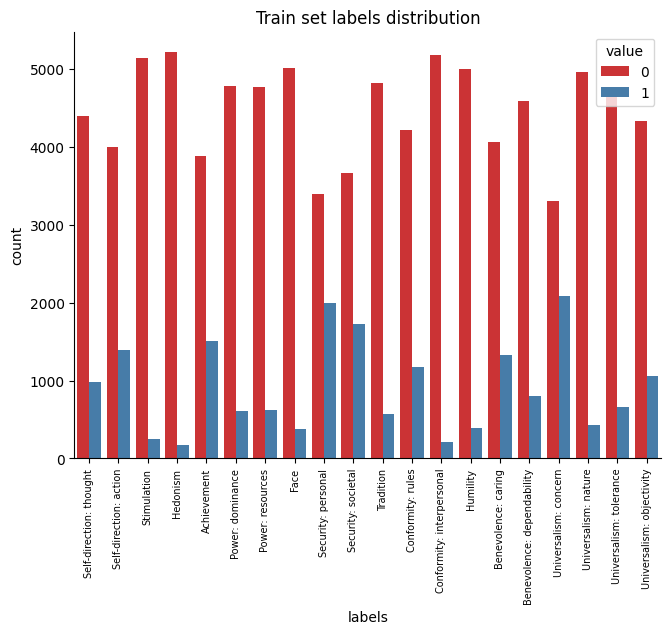

In [ ]:
plot_data = pd.melt(df_train[columns[4:]], var_name='labels')

g = sns.catplot(data=plot_data,  
                x='labels',  
                hue='value',  
                kind='count',  
                height=5,  
                aspect=1.5,  
                palette='Set1',  
                legend_out=False) 
 
g.set_xticklabels(rotation=90, fontsize=7)

plt.title('Train set labels distribution')

Text(0.5, 1.0, 'Validation set labels distribution')

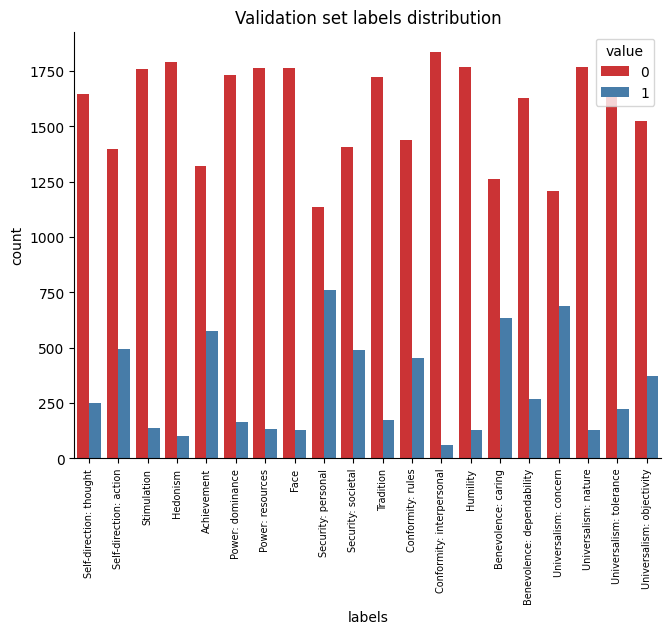

In [ ]:
plot_data = pd.melt(df_val[columns[4:]], var_name='labels')

g = sns.catplot(data=plot_data,  
                x='labels',  
                hue='value',  
                kind='count',  
                height=5,  
                aspect=1.5,  
                palette='Set1',  
                legend_out=False) 

g.set_xticklabels(rotation=90, fontsize=7)

plt.title('Validation set labels distribution')

Text(0.5, 1.0, 'Test set labels distribution')

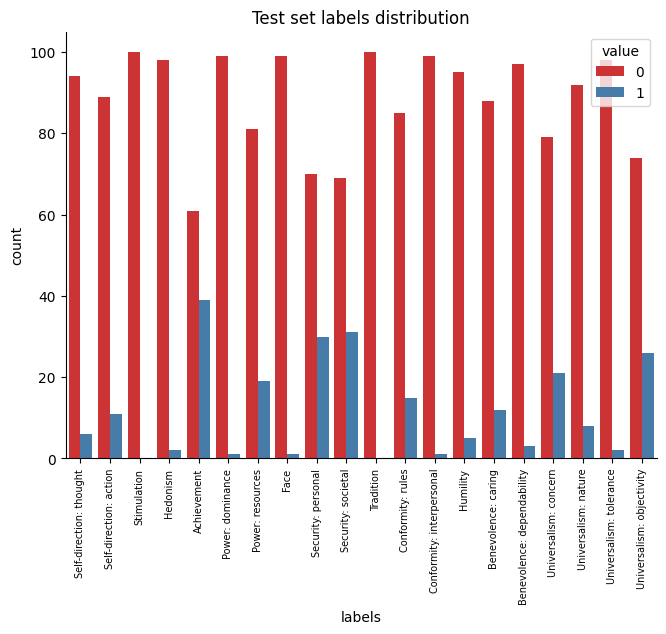

In [ ]:
plot_data = pd.melt(df_test[columns[4:]], var_name='labels')

g = sns.catplot(data=plot_data,  
                x='labels',  
                hue='value',  
                kind='count',  
                height=5,  
                aspect=1.5,  
                palette='Set1',  
                legend_out=False) 

g.set_xticklabels(rotation=90, fontsize=7)

plt.title('Test set labels distribution')

## Preprocessing the Data

Before proceeding with the tokenization of the input, we perform a pre-processing step with the help of the functions presented during the second lab of the course. Specifically, we remove special characters from the text, defined by the variable `replace_by_space_re` and all characters that do not fall within the range defined by `good_symbols_re`. You remove `stopwords` since they are words in the language that are of little use for classification purposes. Finally, all excess spaces are removed.

Among the `stopwords` we decided to keep the words "against" and "favor" since they constitute our `Stance` and will be used during the concatenation of arguments.

In [ ]:
replace_by_space_re = re.compile('[/(){}\[\]\|@,;]')
good_symbols_re = re.compile('[^0-9a-z #+_]')
replace_multiple_spaces_re = re.compile(' +')
good_stopwords = ['favor','against']

try:
    stopwords = set(stopwords.words('english'))
    stopwords = stopwords - set(good_stopwords)
except LookupError:
    nltk.download('stopwords')
    stopwords = set(stopwords.words('english'))
    stopwords = stopwords - set(good_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    """
    return text.lower()
 
def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis, with spacing character
    """
    return replace_by_space_re.sub(' ', text)

def replace_br(text: str) -> str:
    """
    Replaces br characters
    """
    return text.replace('br', '')

def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the good symbols list (check regular expression)
    """
    return good_symbols_re.sub('', text)
 
def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in stopwords])
 
def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from text.
    """
    return text.strip()

def replace_double_spaces(text: str) -> str:
    """
    Replaces special characters, such as paranthesis, with spacing character
    """
    return replace_multiple_spaces_re.sub(' ', text)

In [ ]:
preprocessing_pipeline = [
                          lower,
                          replace_special_characters,
                          replace_br,
                          filter_out_uncommon_symbols,
                          remove_stopwords,
                          strip_text,
                          replace_double_spaces
                          ]

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """
    filter_methods = filter_methods if filter_methods is not None else preprocessing_pipeline
    return reduce(lambda txt, f: f(txt), filter_methods, text)

Once the pre-pocessing steps have been defined, we replace each sentence with its pre-processed version.

In [ ]:
df_train['Conclusion'] = df_train['Conclusion'].apply(lambda txt: text_prepare(txt))
df_train['Stance'] = df_train['Stance'].apply(lambda txt: text_prepare(txt))
df_train['Premise'] = df_train['Premise'].apply(lambda txt: text_prepare(txt))

df_val['Conclusion'] = df_val['Conclusion'].apply(lambda txt: text_prepare(txt))
df_val['Stance'] = df_val['Stance'].apply(lambda txt: text_prepare(txt))
df_val['Premise'] = df_val['Premise'].apply(lambda txt: text_prepare(txt))

df_test['Conclusion'] = df_test['Conclusion'].apply(lambda txt: text_prepare(txt))
df_test['Stance'] = df_test['Stance'].apply(lambda txt: text_prepare(txt))
df_test['Premise'] = df_test['Premise'].apply(lambda txt: text_prepare(txt))

In [ ]:
df_train.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,ban human cloning,favor,ban human cloning cause huge issues bunch huma...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,ban fast food,favor,fast food banned really bad health costly,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A01006,end use economic sanctions,against,sometimes economic sanctions thing get corrupt...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,A01007,abolish capital punishment,against,capital punishment sometimes option keep crimi...,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A01008,ban factory farming,against,factory farming allows production cheap food n...,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [ ]:
df_val.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01001,entrapment legalized,favor,entrapment serve easily capture wanted crimina...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01012,use public defenders mandatory,favor,use public defenders mandatory people dont mon...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,A02001,payday loans banned,favor,payday loans create impoverished society crazy...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,A02002,surrogacy banned,against,surrogacy banned womans right choose wishes an...,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A02009,entrapment legalized,against,entrapment gravely immoral against human right...,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1


In [ ]:
df_test.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,C26001,abolish 996 overtime system,favor,chinas 996 overtime system inefficient enhanci...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,C26002,abolish 996 overtime system,favor,chinas 996 overtime system leaves room learn i...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,C26003,abolish 996 overtime system,against,poor people go internet factory chinas 996 ove...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,C26004,abolish 996 overtime system,favor,chinas 996 overtime system violates labor laws,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,C26005,abolish 996 overtime system,against,corporate management seeks maximize profits ch...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Tokenization

### Choosing the Max Length

To properly choose the `max_length` parameter of the Tokenizer we look at the distribution of the sentence lengths in our dataset and set the parameter to a value that covers the 95% of the sentences. To do so, we can rely on the `np.percentile()` function.

However, for a better visualization of the distribution of sentence lengths, we plot the Box Plot for both Argument's `Premise` and Argument's `[Conclusion, Stance, Premise]` alone.

In [ ]:
conclusions_len = df_train["Conclusion"].apply(len)
stances_len = df_train["Stance"].apply(len)

premises_len = df_train["Premise"].apply(len)
concat_len = conclusions_len + stances_len + premises_len

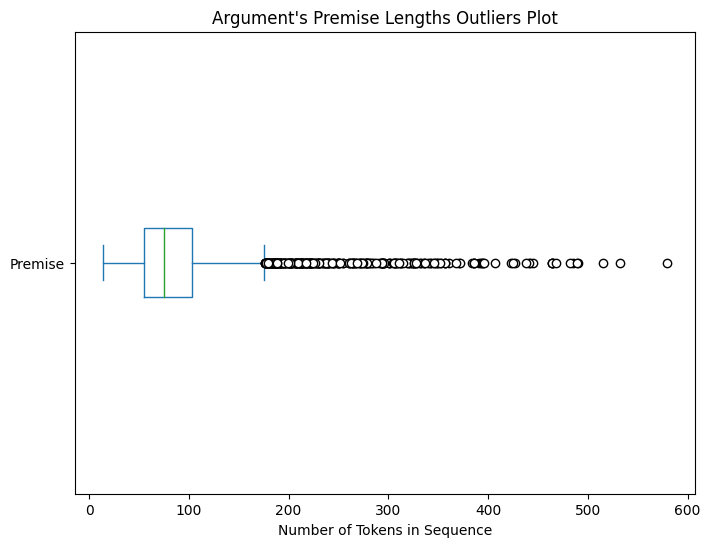

In [ ]:
premises_len.plot.box(figsize=(8, 6), vert=False, flierprops={"marker": "o", "markerfacecolor": "white"})
plt.xlabel("Number of Tokens in Sequence")
plt.title("Argument's Premise Lengths Outliers Plot")
plt.show()

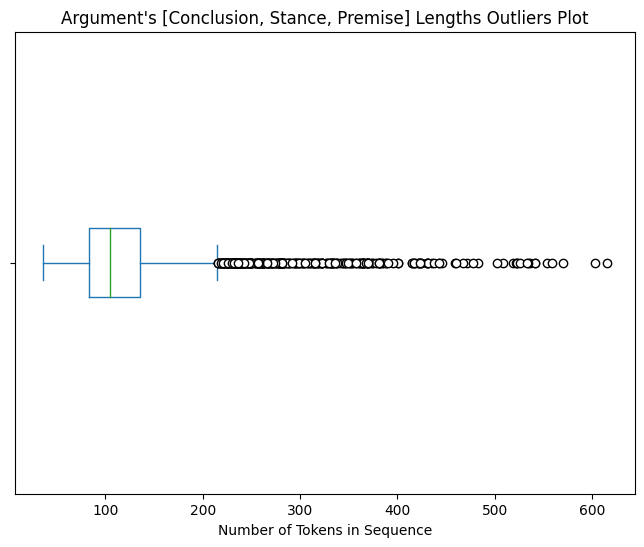

In [ ]:
concat_len.plot.box(figsize=(8, 6), vert=False, flierprops={"marker": "o", "markerfacecolor": "white"})
plt.xlabel("Number of Tokens in Sequence")
plt.title("Argument's [Conclusion, Stance, Premise] Lengths Outliers Plot")
plt.show()

In [ ]:
max_length_no_concat = round(np.percentile(premises_len, 95))
max_length_concat = round(np.percentile(concat_len, 95))

print(max_length_no_concat)
print(max_length_concat)

178
233


We set the final value for `max_len` based on the value of `concat`.

In [ ]:
if concat:
  max_length = max_length_concat
else:
  max_length = max_length_no_concat

### Tokenizer Initialization

We initialize a tokenizer object using the Hugging Face Transformers library. Specifically, we load the tokenizer for the model defined by the `model_names` variable.

In [ ]:
model_names = [
              #"bert-base-uncased",
              #"roberta-base",
               "allenai/multicite-multilabel-scibert"
              ]

model_name = model_names[0]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, truncation=True, padding=True, max_length=max_length)

### Tokenization and Conversion to DatasetDict

In this section, we define two functions and then use them to convert data from pandas DataFrames to Hugging Face Datasets.

The first function, `tokenize_and_encode`, takes as input a dictionary of samples (i.e. a single row from a DataFrame) and a boolean variable `concat`. If `concat` is `True`, it concatenates the `Conclusion`, `Stance`, and `Premise` fields of the sample into a single input string, otherwise it only uses the `Premise` field. The function then uses the tokenizer object (initialized earlier) to tokenize and encode the input string, returning the resulting dictionary of encoded sequences.

The second function, `convert_to_dataset`, takes as input our pandas DataFrames and converts them into Hugging Face Datasets, saves the labels (which are already one-hot encoded) in the `labels` field and applies the `tokenize_and_encode` function to tokenize and encode the input data. The resulting Datasets contains the tokenized and encoded input sequences, as well as the one-hot encoded labels for each sample.

In [ ]:
def tokenize_and_encode(samples, concat):
  if concat:
    input_list = [samples.get(key) for key in ['Conclusion', 'Stance', 'Premise']]
    input = ' '.join(input_list)
  else:
    input_list = [samples.get(key) for key in ['Premise']]
    input = ' '.join(input_list)
  return tokenizer(input)


def convert_to_dataset(df_train, df_val, df_test, columns, concat):
    ds_train = Dataset.from_dict((df_train[columns]).to_dict('list'))
    ds_val = Dataset.from_dict((df_val[columns]).to_dict('list'))
    ds_test = Dataset.from_dict((df_test[columns]).to_dict('list')) 

    ds = DatasetDict()
    ds['train'] = ds_train
    ds['eval'] = ds_val
    ds['test'] = ds_test

    ds = ds.map(lambda x: {"labels": [float(x[c]) for c in columns[4:]]}) # put the one hot encoded row as a list in labels

    ds = ds.map(lambda x: tokenize_and_encode(x, concat), remove_columns=columns) #remove the header of the columns   
    
    return ds, columns[4:]

Finally, we assign the dataset to give in input to the model and print out its structure.

In [ ]:
if concat:
  ds, labels = convert_to_dataset(df_train, df_val, df_test, columns, concat)
else:
  ds, labels = convert_to_dataset(df_train, df_val, df_test, columns, concat)

print(ds) 

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5393
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1896
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 100
    })
})


### Tokenization Example

In the following example we choose a random sample from the train, validation or test encoded set and we decode it with the `decode()` function of the Tokenizer. 

In [ ]:
split = ['train','eval','test']
random_split = random.randint(0,2)
random_sample = random.randint(0,len(ds[split[random_split]]))

print(f'Encoded sample taken from {split[random_split]} dataset:\n', ds[split[random_split]][random_sample]["input_ids"])
decoded_sample = tokenizer.decode(ds[split[random_split]][random_sample]["input_ids"])
print(f'Decoded sample taken from {split[random_split]} dataset:\n', decoded_sample)

Encoded sample taken from test dataset:
 [101, 2484, 8292, 2993, 12167, 14847, 295, 334, 725, 6782, 417, 1310, 4642, 138, 4695, 2173, 2788, 620, 6304, 6032, 3842, 2474, 30111, 7902, 8249, 30111, 102]
Decoded sample taken from test dataset:
 [CLS] future rural market certainly prosperous present barren risk investing business still relatively high largely limits young peoples footsteps [SEP]


## Model Definition

Here we initialize a sequence classification model object which loads the pre-trained weights defined by `model_name` from Hugging Face's model hub. In particular, the `AutoModelForSequenceClassification` class is a pre-built model class that is designed for sequence classification tasks, such as sentiment analysis or text classification.

The `problem_type` argument is set to `multi_label_classification` which indicates that the model will be trained to predict multiple labels for each input sequence.

Moreover, setting `ignore_mismatched_sizes=True` is necessary for the `allenai/multicite-multilabel-scibert` model because it uses a variant of the SciBERT architecture that expects fixed-length input sequences. If this parameter is set to `False` and the model encounters a sequence with a different length than it was trained on, it will raise an error.

By setting `ignore_mismatched_sizes=True`, the model will automatically truncate or pad input sequences to the appropriate length during training and inference, allowing it to handle input sequences of varying lengths without raising an error.

In [ ]:
num_labels = len(labels)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=num_labels,
                                                           ignore_mismatched_sizes=True
                                                           )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/multicite-multilabel-scibert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([20, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([20]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model = model.to(device)

### Model Structure

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31116, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Model Training

### Definition of the Evaluation Metrics

We define the `compute_metrics` function to compute the evaluation metrics on the model's predictions for the validation and test datasets.

The function first loops over a range of threshold values from 0.1 to 0.95 with a step of 0.05. For each threshold, the function normalizes the model's predictions using the sigmoid function and then converts the predicted probabilities to binary labels based on whether they are greater or less than the threshold. The function then computes the macro F1-score, precision, and recall for the binary labels.

The purpose of using a range of threshold values is to find the optimal threshold that maximizes the F1-score on the validation set.

In [ ]:
best_threshold = 0.0

In [ ]:
def compute_metrics(eval_predictions):

  best_f1 = 0.0
  best_precision = 0.0
  best_recall = 0.0

  for threshold in np.arange(0.1, 0.95, 0.05):

    predictions, labels = eval_predictions

    # Normalize the predictions
    predictions = torch.from_numpy(predictions).sigmoid().numpy()

    # Convert the predicted probabilities to binary labels
    eval_preds = np.where(predictions > threshold, 1.0, 0.0)

    # Compute the evaluation metrics
    f1 = f1_score(labels, eval_preds, average='macro', zero_division=0)
    precision = precision_score(labels, eval_preds, average='macro', zero_division=0)
    recall = recall_score(labels, eval_preds, average='macro', zero_division=0)

    # Update the threshold based on the best F1 score seen so far
    if f1 > best_f1:
        best_f1 = f1
        best_precision = precision
        best_recall = recall
        global best_threshold
        best_threshold = threshold

    # Print the F1 score and threshold for each evaluation step
    # print(f'F1 score: {f1:.4f} - Threshold: {threshold:.2f}')

  print(f'Best F1 score: {best_f1:.4f} - Best Threshold: {best_threshold:.2f}')

  return {'precision': best_precision, 'recall': best_recall, 'f1': best_f1}

### Hyperparameters Definition

In [ ]:
batch_size_train = 128
batch_size_eval = 128
lr = 2e-5 #1e-5
num_train_epochs = 20
weight_decay=0.1 #0.01
seed = 42

In [ ]:
args = TrainingArguments(
                         model_name,
                         evaluation_strategy = "epoch",
                         save_strategy = "epoch", # parametro attivato per EarlyStopping
                         logging_strategy='epoch',
                         learning_rate=lr,
                         per_device_train_batch_size=batch_size_train,
                         per_device_eval_batch_size=batch_size_eval,
                         num_train_epochs=num_train_epochs,
                         weight_decay=weight_decay,
                         load_best_model_at_end=True, # flag attivato per EarlyStopping
                         seed=seed,
                         )

### Custom Trainer Instantiation

In this section, we define a `CustomizeTrainer` to use a weighted loss (useful when we have an unbalanced training set).

In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss = torch.nn.BCEWithLogitsLoss()(logits,labels)
        return (loss, outputs) if return_outputs else loss

In particular, the `nn.BCEWithLogitsLoss()` assumes that the labels are encoded as binary indicators, where each sample can be associated with multiple classes. This means that the labels can be encoded as a tensor of binary values, where each element corresponds to a different class. The `BCE` stands for binary cross-entropy, and the `WithLogits` means that the function expects the output of the neural network to be unnormalized logits, rather than probabilities.

In [ ]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience = 3, # number of times to wait without improvement before stopping
    early_stopping_threshold = 0.001 # minimum improvement required to count as improvement
)

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=ds["train"],
    eval_dataset=ds["eval"],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_preds: compute_metrics(eval_preds),
    callbacks=[early_stopping_callback]  # add the early stopping callback
)

### Training

In [ ]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.471500,0.412096,0.160263,0.834615,0.257415
2,0.407400,0.388669,0.192567,0.825106,0.292058
3,0.380000,0.375248,0.243051,0.621668,0.321046
4,0.358900,0.365566,0.228563,0.729326,0.331838
5,0.344500,0.358718,0.290564,0.592842,0.365510
6,0.330900,0.358052,0.317561,0.584392,0.370259
7,0.320900,0.352412,0.304100,0.609760,0.389169
8,0.308500,0.350244,0.314089,0.604015,0.397201
9,0.299100,0.351457,0.351664,0.527409,0.404273
10,0.290600,0.351921,0.320968,0.598737,0.403560


Best F1 score: 0.2574 - Best Threshold: 0.10
Best F1 score: 0.2921 - Best Threshold: 0.10
Best F1 score: 0.3210 - Best Threshold: 0.15
Best F1 score: 0.3318 - Best Threshold: 0.10
Best F1 score: 0.3655 - Best Threshold: 0.15
Best F1 score: 0.3703 - Best Threshold: 0.15
Best F1 score: 0.3892 - Best Threshold: 0.15
Best F1 score: 0.3972 - Best Threshold: 0.15
Best F1 score: 0.4043 - Best Threshold: 0.20
Best F1 score: 0.4036 - Best Threshold: 0.15
Best F1 score: 0.4025 - Best Threshold: 0.15


TrainOutput(global_step=473, training_loss=0.3448997723375768, metrics={'train_runtime': 676.2649, 'train_samples_per_second': 159.494, 'train_steps_per_second': 1.272, 'total_flos': 2054868121857144.0, 'train_loss': 0.3448997723375768, 'epoch': 11.0})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
link = '/content/drive/MyDrive/UNIBO/NLP/STANDARD_PROJECT' 

link = link + "/" + model_name

trainer.save_model(link)  # Saving model weights

Mounted at /content/drive


## Evaluation

In [ ]:
trainer.evaluate()

Best F1 score: 0.3972 - Best Threshold: 0.15


{'eval_loss': 0.35024380683898926,
 'eval_precision': 0.3140887502468008,
 'eval_recall': 0.6040149425127118,
 'eval_f1': 0.3972013308142194,
 'eval_runtime': 5.1143,
 'eval_samples_per_second': 370.725,
 'eval_steps_per_second': 2.933,
 'epoch': 11.0}

## Prediction

In [ ]:
test_predictions, test_ids, test_metrics = trainer.predict(ds['test'])

Best F1 score: 0.2737 - Best Threshold: 0.15


## Inference

In this section play with our model by giving it as input any sentence and having it return the list of predicted labels associated with that sentence.

In [ ]:
id2label = {
 0:'Self-direction: thought',
 1:'Self-direction: action',
 2:'Stimulation',
 3:'Hedonism',
 4:'Achievement',
 5:'Power: dominance',
 6:'Power: resources',
 7:'Face',
 8:'Security: personal',
 9:'Security: societal',
 10:'Tradition',
 11:'Conformity: rules',
 12:'Conformity: interpersonal',
 13:'Humility',
 14:'Benevolence: caring',
 15:'Benevolence: dependability',
 16:'Universalism: concern',
 17:'Universalism: nature',
 18:'Universalism: tolerance',
 19:'Universalism: objectivity'}

In [ ]:
my_sentence = "We should legalize the use of marijuana since it is shown in scientific studies to have a beneficial effect for people with anxiety conditions."
#my_sentence = "Young people should practice more sport, in particular swimming since it is the most complete sport for good health."

def inference(my_sentence, threshold):

  # Pre-process the sentence
  input_text = text_prepare(my_sentence)

  # Tokenize it
  input_text = tokenizer(input_text, return_tensors = 'pt' ) #dizionario con key 'input_ids' 

  for key in input_text:
    input_text[key] = input_text[key].to(device)

  # Give it to the model
  with torch.no_grad():
    output_predictions = model(input_text['input_ids'])
    output_predictions = {key: output.cpu() for key, output in output_predictions.items()}
  
  # Normalize and binarize the output
  output_predictions = output_predictions['logits'].sigmoid().numpy()
  output_predictions = np.where(output_predictions > threshold, 1.0, 0.0) 

  # Use the lab2input dictionary to obtain the predicted labels
  output_labels = np.where(output_predictions == 1.0)
  
  # Transform them in a list of indeces
  output_labels = output_labels[1].tolist()
  output_labels = [id2label[idx] for idx in output_labels]
  print("The predicted labels are:\n", output_labels)

In [ ]:
inference(my_sentence, best_threshold)

The predicted labels are:
 ['Self-direction: thought', 'Self-direction: action', 'Achievement', 'Security: personal', 'Benevolence: caring', 'Benevolence: dependability', 'Universalism: objectivity']
